# DATA PREPROCESSING AND MODELLING #
This notebook shows the code used for preprocessing and modelling

## Step 1. Import Libraries ##

In [1]:

# Imports.

import pandas as pd
import numpy as np
import joblib
import warnings
import os
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import FuncFormatter
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import PowerTransformer
from scipy import stats

# Warnings Suppression.

warnings.filterwarnings("ignore")
os.environ['LIGHTGBM_VERBOSE'] = '-1'

## Step 2. Exploratory Data Analysis ##

In [2]:
# Load Cleaned Data.

df = pd.read_csv("../data/cleaned_data_final.csv")

print(f"Shape: {df.shape}")
df.head()

Shape: (28960, 10)


,Location,Type,Rooms,Bathrooms,Car Parks,Size,Furnishing,Storeys,Position,Price
0,KLCC,Serviced Residence,3,3.0,2.0,1335,Fully Furnished,1,Unknown,1250000
1,Dutamas,Condominium,3,4.0,2.0,1875,Partly Furnished,1,Corner,1030000
2,Bukit Jalil,Condominium,5,3.0,2.0,1513,Partly Furnished,1,Corner,900000
3,Taman Tun Dr Ismail,Bungalow,6,5.0,4.0,7200,Partly Furnished,1,Unknown,5350000
4,Taman Tun Dr Ismail,Semi-detached House,5,4.0,4.0,3600,Partly Furnished,1,Unknown,2600000


In [3]:
# Basic info and descriptive statistics of the dataset.

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28960 entries, 0 to 28959
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Location    28960 non-null  object 
 1   Type        28960 non-null  object 
 2   Rooms       28960 non-null  int64  
 3   Bathrooms   28960 non-null  float64
 4   Car Parks   28960 non-null  float64
 5   Size        28960 non-null  int64  
 6   Furnishing  28960 non-null  object 
 7   Storeys     28960 non-null  int64  
 8   Position    28960 non-null  object 
 9   Price       28960 non-null  int64  
dtypes: float64(2), int64(4), object(4)
memory usage: 2.2+ MB


,Rooms,Bathrooms,Car Parks,Size,Storeys,Price
count,28960.000000,28960.000000,28960.000000,28960.000000,28960.000000,2.896000e+04
mean,3.438709,2.790193,1.829282,1669.750760,1.121789,1.317016e+06
std,1.208920,1.287033,0.827669,1140.877681,0.412579,1.251854e+06
min,1.000000,1.000000,1.000000,413.000000,1.000000,1.250000e+05
25%,3.000000,2.000000,1.000000,1000.000000,1.000000,5.530000e+05
50%,3.000000,2.000000,2.000000,1300.000000,1.000000,8.600000e+05
75%,4.000000,4.000000,2.000000,1840.000000,1.000000,1.560000e+06
max,7.000000,7.000000,4.000000,10000.000000,4.000000,1.000000e+07


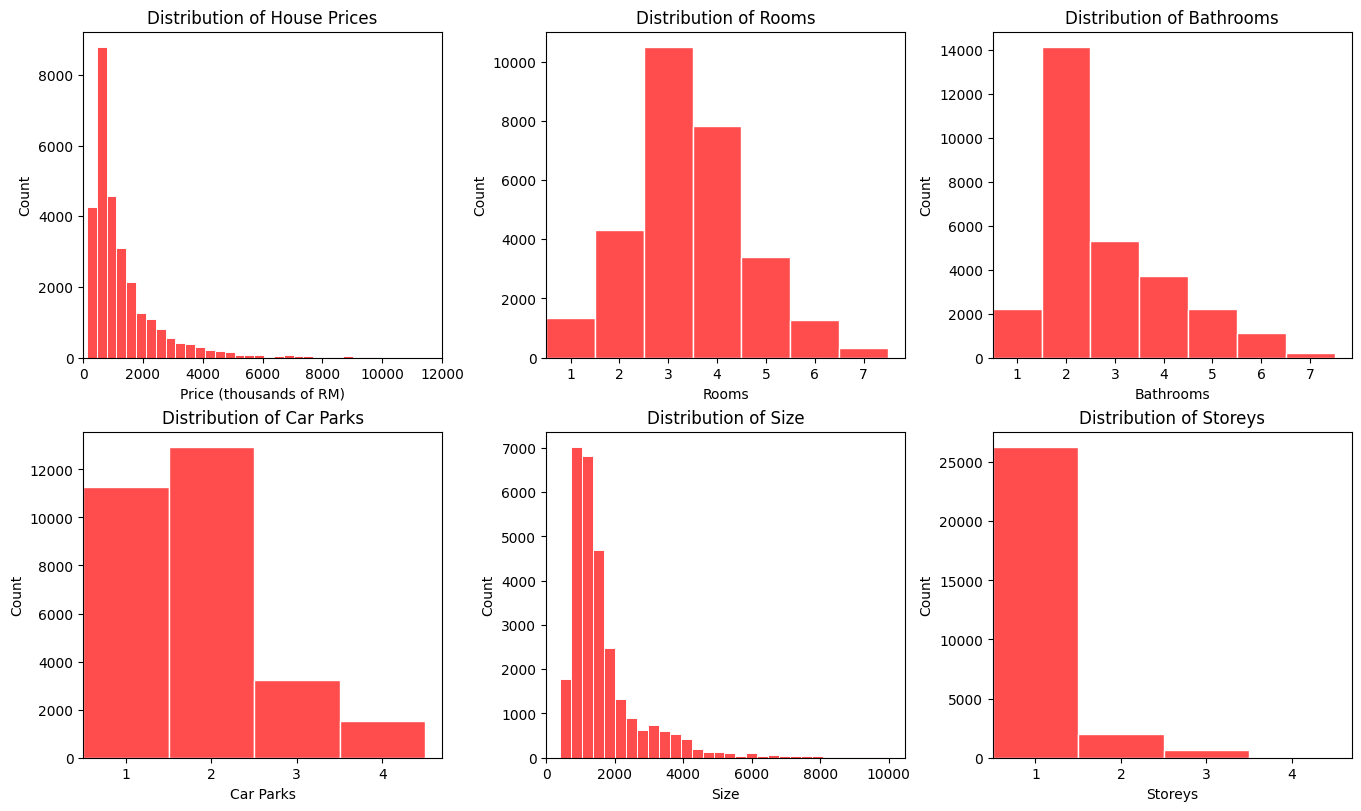

In [4]:

# 1.Plot histograms for numeric columns

cols = ['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Storeys']

# 2. Layout

n_cols = 3
n_rows = (len(cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(4.5 * n_cols, 4 * n_rows),
                         constrained_layout=True)
axes = np.ravel(axes)


# 3. Common histogram style (red bars, white edges)

hist_kws = dict(color='red', edgecolor='white', alpha=0.7)

for i, col in enumerate(cols):
    ax = axes[i]
    data = df[col].dropna()

    # Binning 
    if col in ['Rooms', 'Bathrooms', 'Car Parks', 'Storeys']:
        # One bin per integer → bars touch each other
        bins = np.arange(data.min(), data.max() + 2) - 0.5
    else:
        bins = 30  # same as original Price plot

    # Plot histogram only
    sns.histplot(data, bins=bins, kde=False, ax=ax, **hist_kws)

    # Axis formatting
    if col == 'Price':
        ax.set_xlim(left=0)
        ticks = ax.get_xticks()
        valid = ticks[ticks >= 0]
        ax.set_xticks(valid)
        ax.set_xticklabels([f'{int(t/1000)}' for t in valid])
        ax.set_xlabel('Price (thousands of RM)')
        ax.set_title('Distribution of House Prices')
    else:
        ax.set_xlim(left=data.min() - 0.5 if col in ['Rooms','Bathrooms','Car Parks','Storeys'] else 0)
        ax.set_xlabel(col)
        ax.set_title(f'Distribution of {col}')

    ax.set_ylabel('Count')

# 4. Remove empty subplots

for i in range(len(cols), len(axes)):
    fig.delaxes(axes[i])

plt.show()

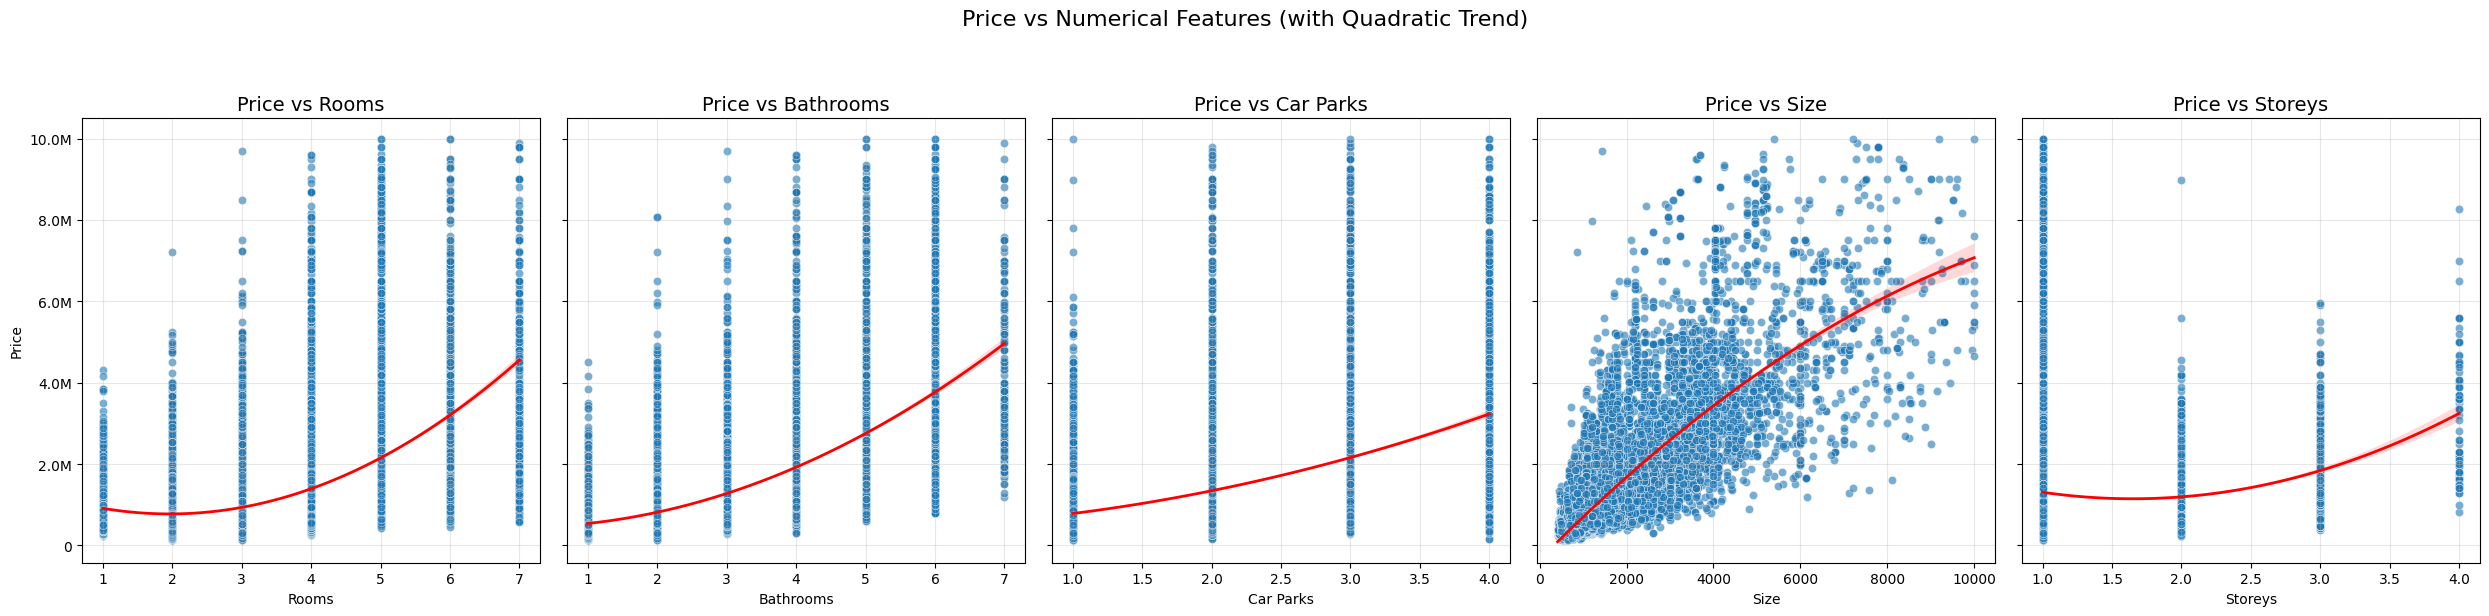

In [5]:
# Plot scatter plots with quadratic trend lines for numerical columns vs Price.

# 1. Columns to plot

num_cols = ['Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Storeys']


# 2. Price formatter (K, M, …)

def price_fmt(x, pos):
    if x >= 1e6:
        return f'{x/1e6:.1f}M'.rstrip('0').rstrip('.')
    if x >= 1e3:
        return f'{int(x/1e3)}K'
    return f'{int(x)}'

fmt = FuncFormatter(price_fmt)


# 3. Create a single figure with subplots

n_cols = len(num_cols)
fig, axes = plt.subplots(1, n_cols, figsize=(5 * n_cols, 6), sharey=True)

# Ensure axes is always a list (handles case when n_cols == 1)
if n_cols == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for i, (ax, col) in enumerate(zip(axes, num_cols)):
    # Scatter plot
    sns.scatterplot(data=df, x=col, y='Price',
                    alpha=0.6, ax=ax, color='#1f77b4')
    
    # Quadratic trend line
    sns.regplot(data=df, x=col, y='Price',
                scatter=False, order=2,
                color='red', line_kws={'lw': 2}, ax=ax)
    
    # Formatting
    ax.set_title(f'Price vs {col}', fontsize=14)
    ax.set_xlabel(col)
    
    # Only show y-label on the first subplot
    if i == 0:
        ax.set_ylabel('Price')
    else:
        ax.set_ylabel('')
    
    ax.yaxis.set_major_formatter(fmt)
    ax.grid(True, alpha=0.3)  # Optional: light grid

# Overall title and layout
fig.suptitle('Price vs Numerical Features (with Quadratic Trend)', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
plt.show()

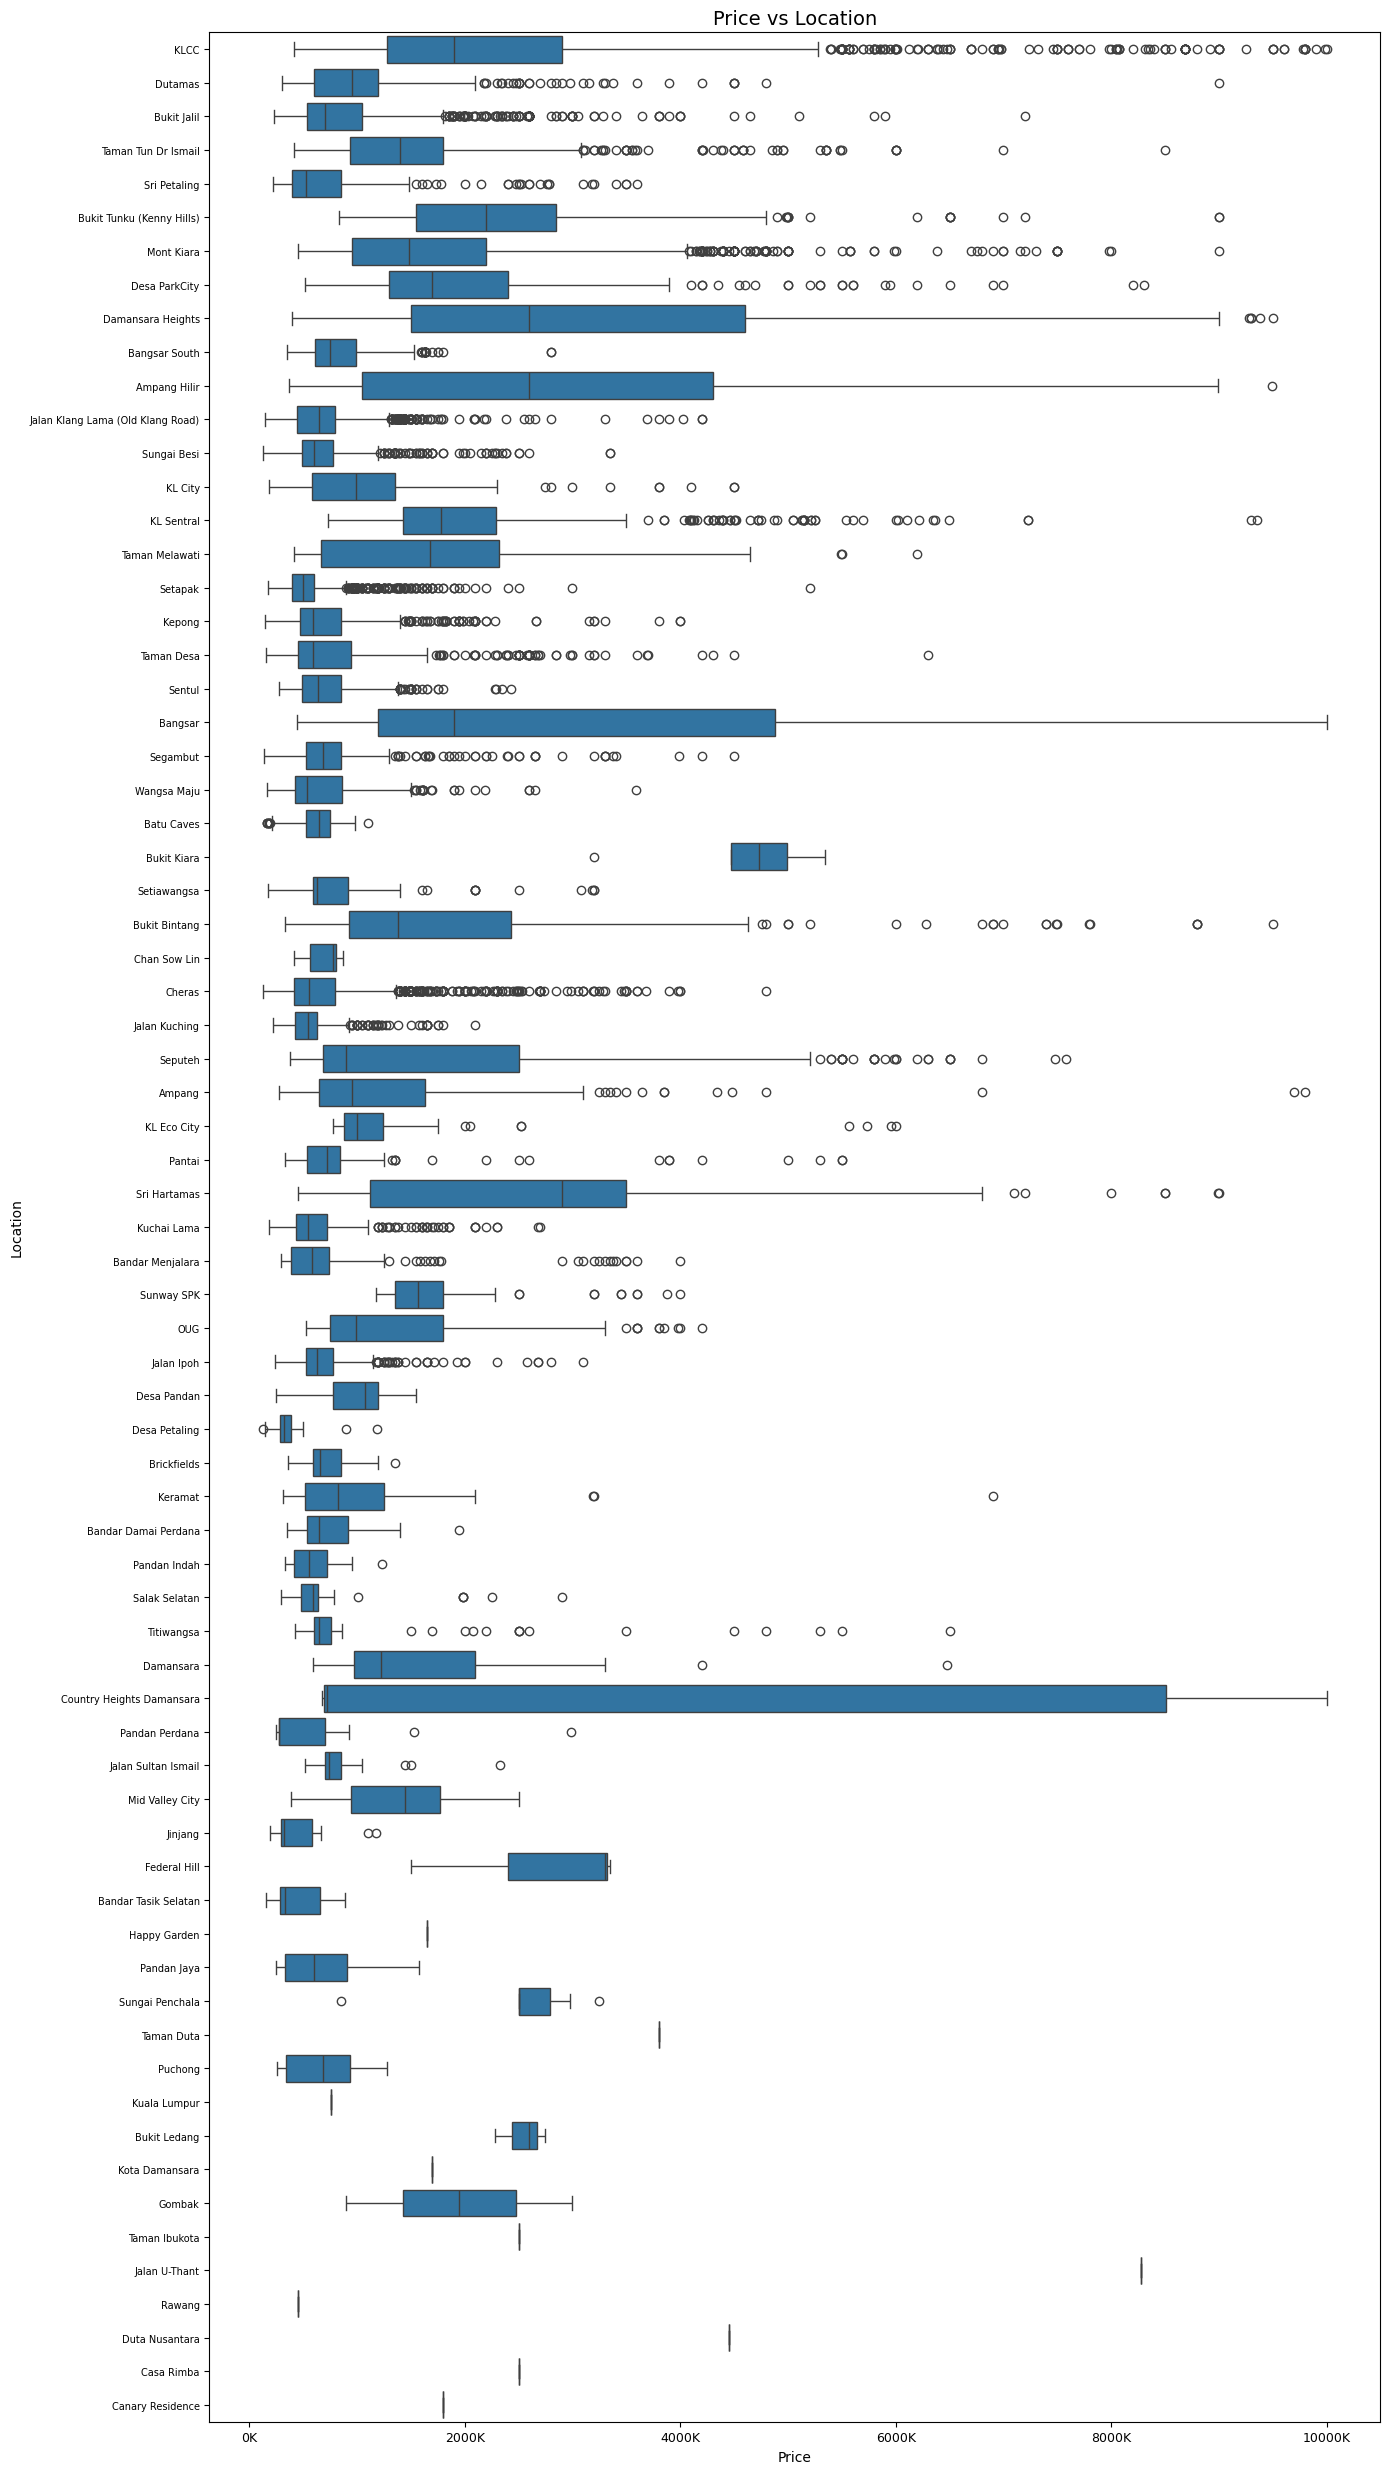

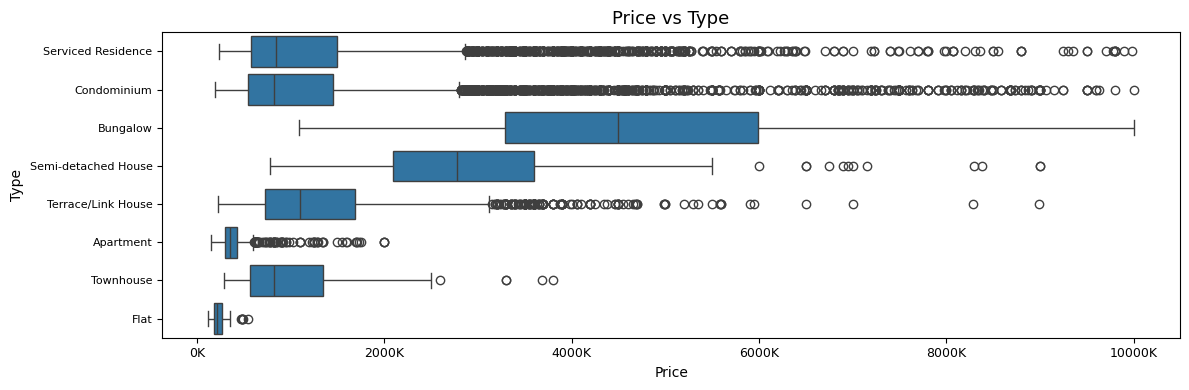

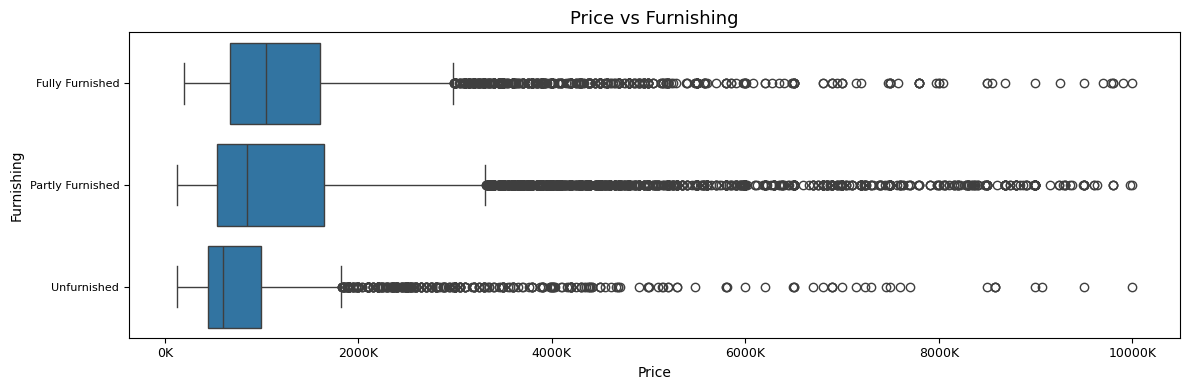

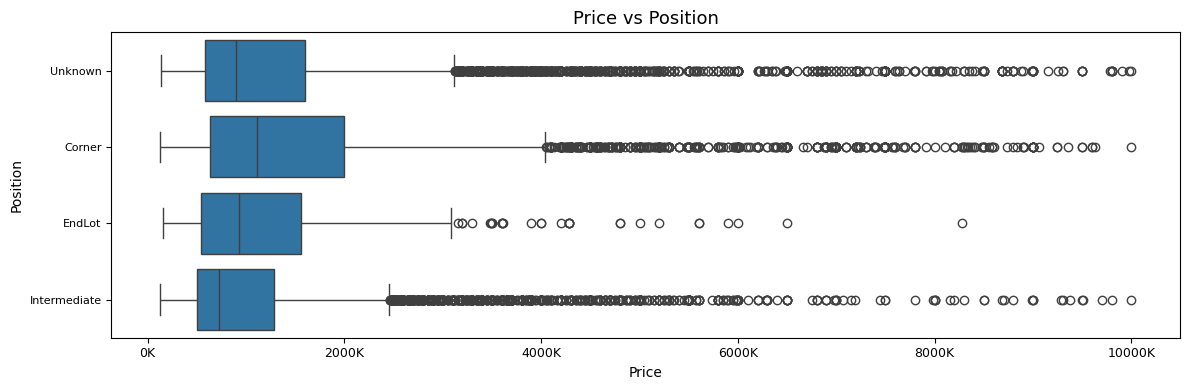

In [6]:
# Plot histograms for categorical columns vs Price

cat_cols = ['Location', 'Type', 'Furnishing', 'Position']

# Define formatter to show prices in thousands
def thousands(x, pos):
    return f'{int(x/1000)}K'

formatter = FuncFormatter(thousands)

for col in cat_cols:
    if col == 'Location':
        n_categories = df[col].nunique()
        height = max(8, n_categories * 0.35)
        fig, ax = plt.subplots(figsize=(14, height))
        sns.boxplot(x='Price', y=col, data=df, ax=ax, orient='h')
        ax.set_title(f'Price vs {col}', fontsize=14)
        ax.tick_params(axis='y', labelsize=7)
        ax.tick_params(axis='x', labelsize=9)
        ax.xaxis.set_major_formatter(formatter)
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(x='Price', y=col, data=df, ax=ax, orient='h')
        ax.set_title(f'Price vs {col}', fontsize=13)
        ax.tick_params(axis='y', labelsize=8)
        ax.tick_params(axis='x', labelsize=9)
        ax.xaxis.set_major_formatter(formatter)
        plt.tight_layout()
        plt.show()


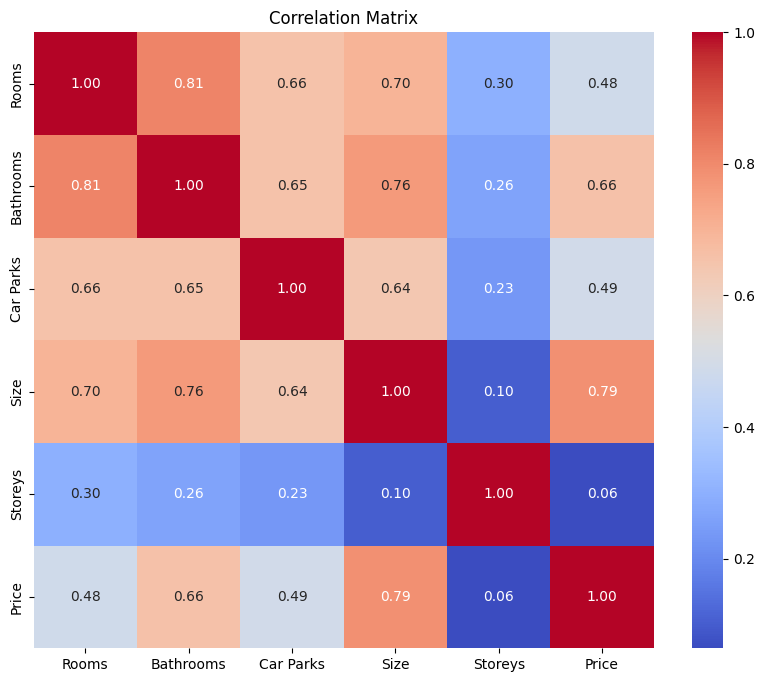

In [7]:
# Generate a correlation heatmap (numeric data)

num_cols = df.select_dtypes(include=np.number).columns.drop('Price')
corr = df[num_cols.tolist() + ['Price']].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


### Interpretation of EDA
The price histogram reveals a right-skewed distribution centered between 0.05 – 0.1 million and including a heavy tail out past the 0.6 million mark, indicating that it will likely work better to make a log transformation of the Price variable, in order to make the target more normally distributed and to make linear models more viable, although tree based models would be less sensitive to this skewed distribution. In the Price vs Location plot there is a large spread where median prices are high for Bangsar, KLCC, and Damansara (~0.5 – 0.9 million) with many outliers priced over the 1 million mark, while lower cost districts are below 0.2 million, thus indicating that this categorical attribute with high cardinality would benefit from target-encoding or frequency- encoding in analyzing itIn the Price vs Type analysis, the Serviced Residences, Condominiums, and Bungalows had the highest medians (~0.6-0.9 million) and Flats and Townhouses had the lowest median prices, indicating that this categorical variable can be encoded in an ordinal or one-hot fashion, since it has a manageable eight levels. The relationship between Price and Furnishing shows a strong upward trend - Fully Furnished > Partially Furnished > Unfurnished - suggesting that ordinal encoding (eg. 0/1/2) would be feasible. Price vs. Position suggests that a Corner Lot and Unknown Lot are prices slightly higher, while EndLot and Inteermediate are very close, hence nominal encoding can use either a one-hot or target approach. Based on the correlation matrix, Size (0.79) is the most correlated with the Price, followed by Bathrooms (0.66), Car Parks (0.49), and Rooms (0.48), and Storeys (0.06) is nearly irrelevant, therefore if multicollinearity appears after encoding, Storeys can be discarded. 

Size emerges as the clear front-runner linear predictor of house prices in our dataset. It displays a very strong positive correlation with price and a marked positive trend on the scatter plot. Rooms and Bathrooms are strong predictors of price, but they are markedly non-linear with plateaus in the relationship beyond 5 rooms or 4 bathrooms which demonstrates diminishing marginal returns. Car Parks shows a consistent positive relationship with price upto 3 car parks, which have jumps at each of the discrete price categories. Storeys include the weakest predictor of house prices in this analysis with either a U-shape or flat shape of relationship due to the potential confound of property type. A strong modeling approach is to log(size), cap the number of rooms at 5 and bathrooms at 4, treat car parks as ordinal upto 3, and include the number of storeys as a polynomial term. Also, the data suggest XGBoost can be included in each capacity with the price log(-transformed) to create the best model which enables non-linearities and interactions while also having the potential of managing outliers, in addition to beyond polynomial terms by feature interactions (e.g size × rooms) and potentially segment by property type/location to produce a better result.

In [8]:
# Remove outliers
# Remove Price outliers within each group of categorical columns
cat_cols = ['Location', 'Type', 'Furnishing', 'Position']

df_clean = df.copy()
for col in cat_cols:
    def remove_group_outliers(group, factor=0.8):
        Q1 = group['Price'].quantile(0.25)
        Q3 = group['Price'].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        return group[(group['Price'] >= lower) & (group['Price'] <= upper)]
    
    df_clean = df_clean.groupby(col, group_keys=False).apply(remove_group_outliers)

df_cleaned = df_clean.reset_index(drop=True)
print(f"Outlier removal complete. Rows: {df_cleaned.shape[0]}, Columns: {df_cleaned.shape[1]}")

Outlier removal complete. Rows: 18816, Columns: 10


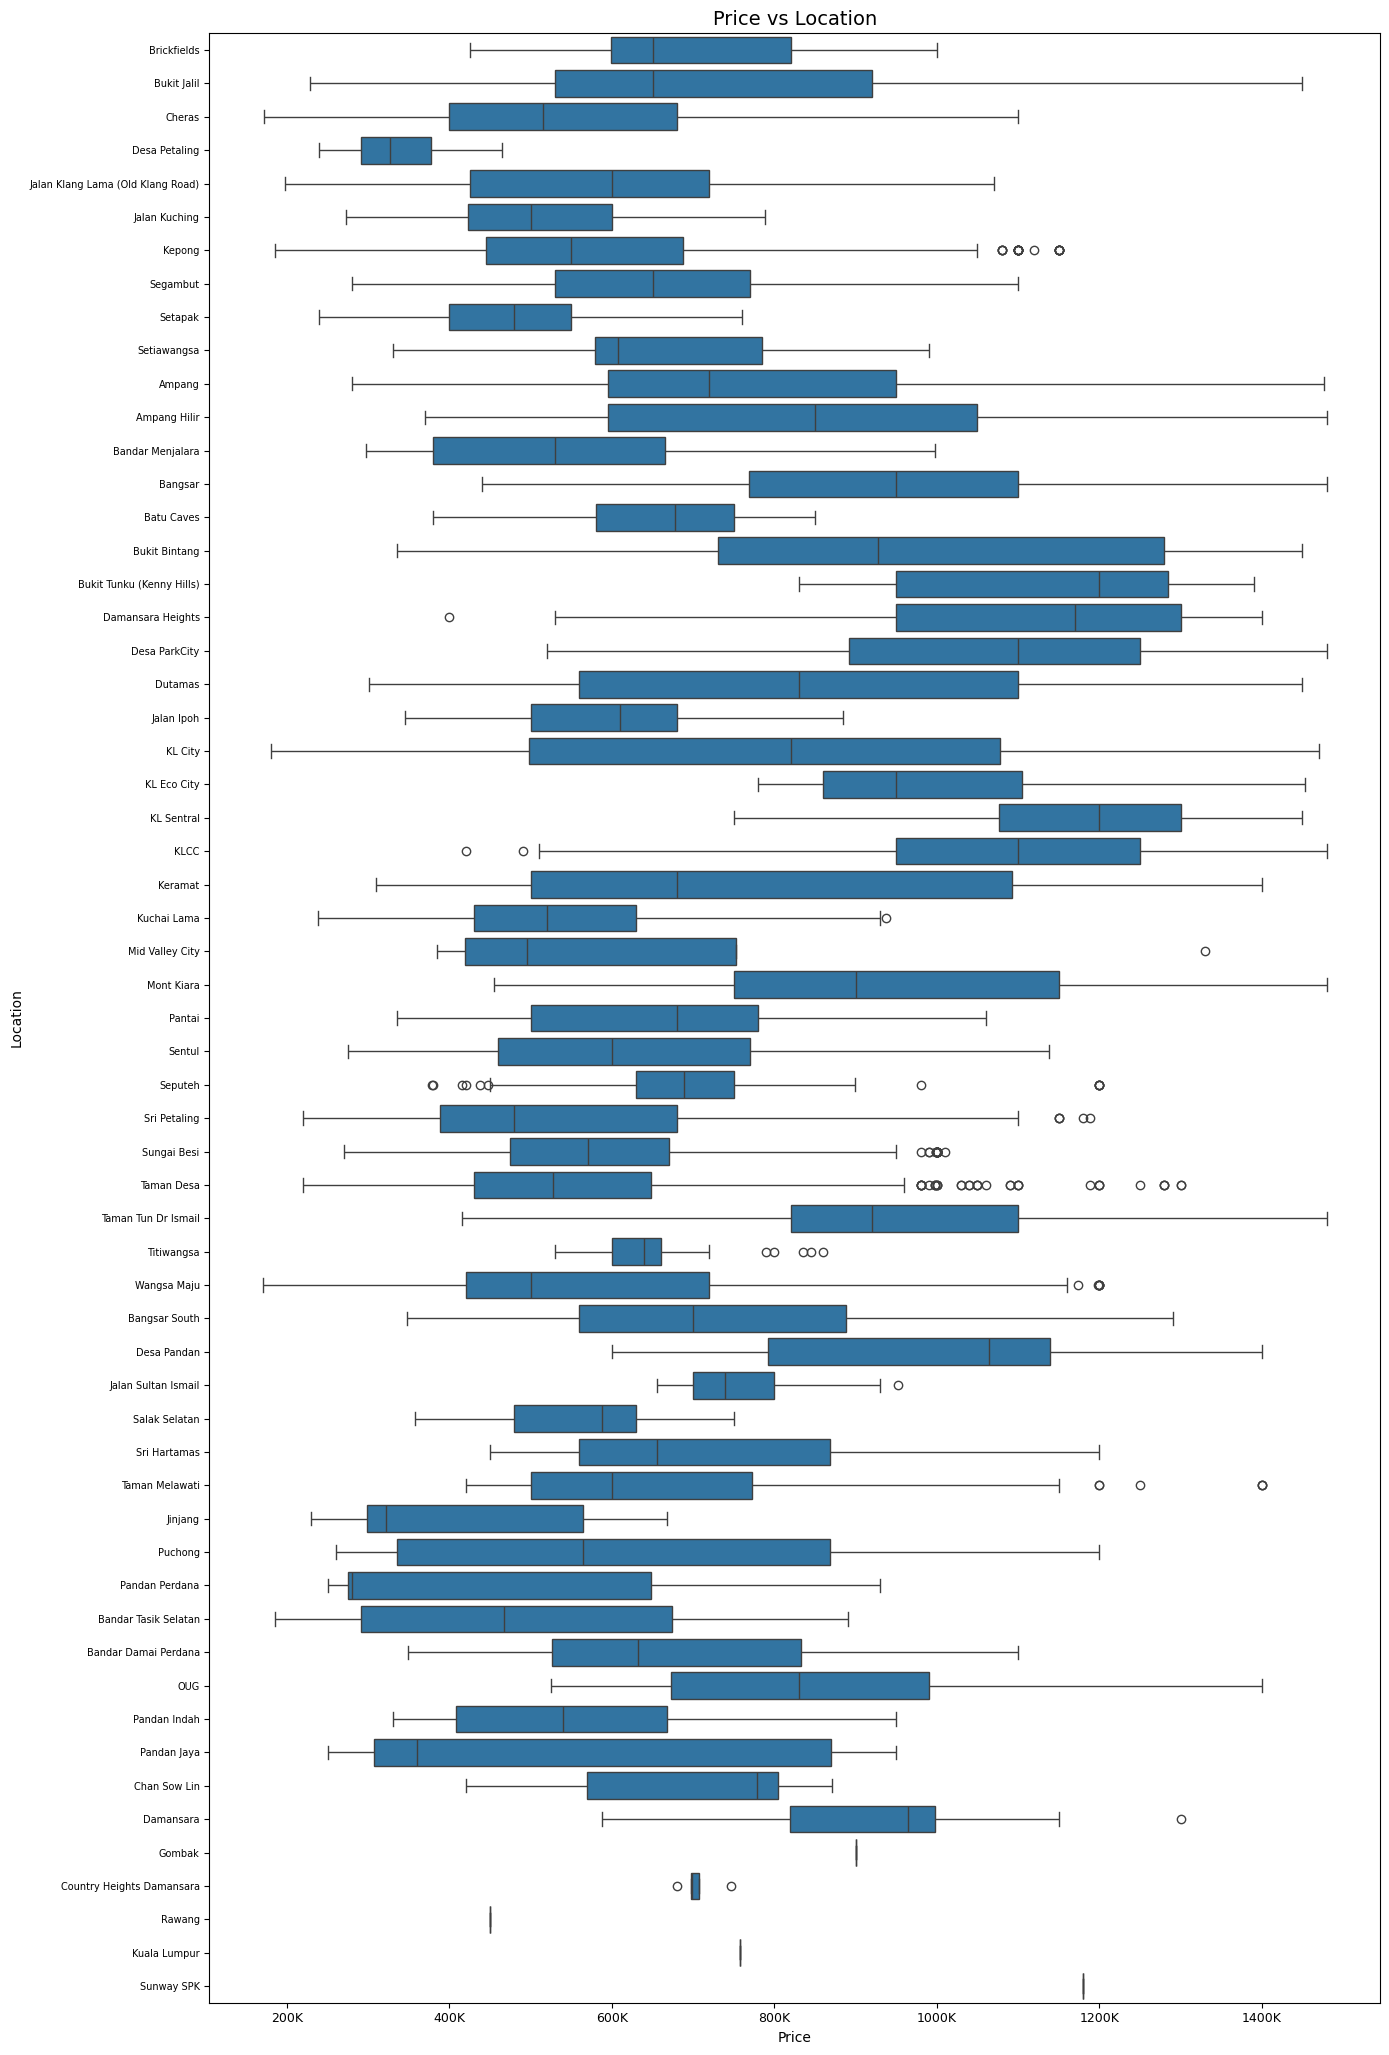

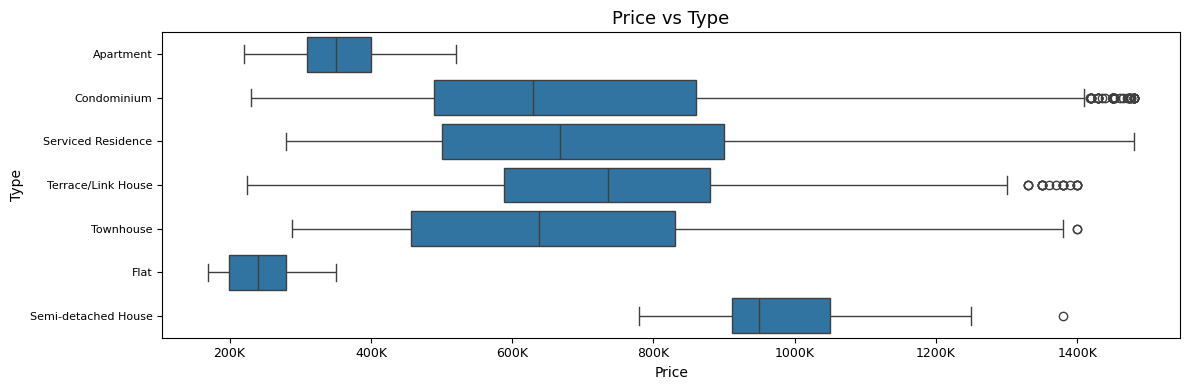

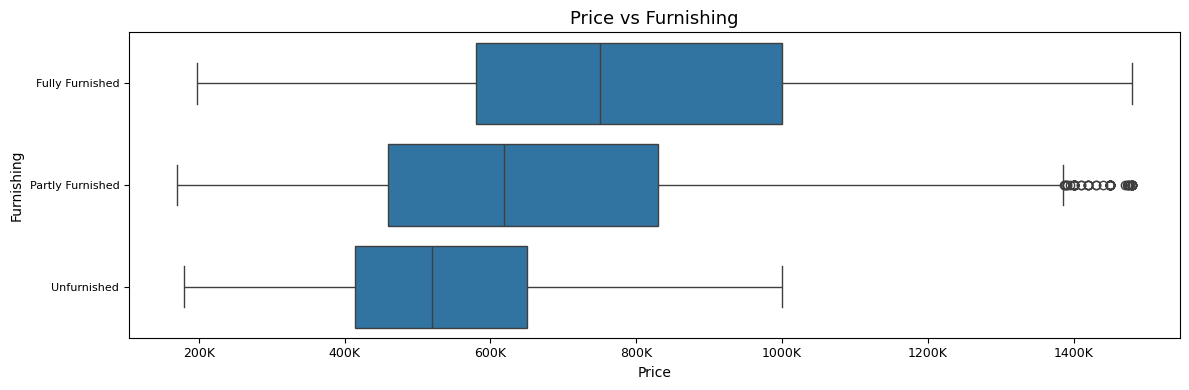

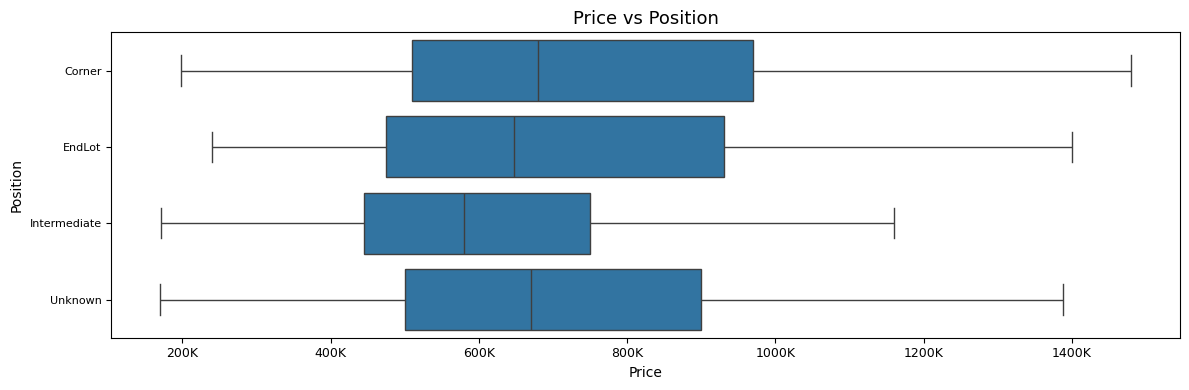

In [10]:
# Replot boxplots for categorical features against 'Price' after outlier removal.

cat_cols = ['Location', 'Type', 'Furnishing', 'Position']

# Define formatter to show prices in thousands
def thousands(x, pos):
    return f'{int(x/1000)}K'

formatter = FuncFormatter(thousands)

for col in cat_cols:
    if col == 'Location':
        n_categories = df_cleaned[col].nunique()
        height = max(8, n_categories * 0.35)
        fig, ax = plt.subplots(figsize=(14, height))
        sns.boxplot(x='Price', y=col, data=df_cleaned, ax=ax, orient='h')
        ax.set_title(f'Price vs {col}', fontsize=14)
        ax.tick_params(axis='y', labelsize=7)
        ax.tick_params(axis='x', labelsize=9)
        ax.xaxis.set_major_formatter(formatter)
        plt.tight_layout()
        plt.show()
    else:
        fig, ax = plt.subplots(figsize=(12, 4))
        sns.boxplot(x='Price', y=col, data=df_cleaned, ax=ax, orient='h')
        ax.set_title(f'Price vs {col}', fontsize=13)
        ax.tick_params(axis='y', labelsize=8)
        ax.tick_params(axis='x', labelsize=9)
        ax.xaxis.set_major_formatter(formatter)
        plt.tight_layout()
        plt.show()


In [12]:
# Final shape after outlier removal.

df_cleaned.shape

(18816, 10)

## Step 3. Data Transformation ##

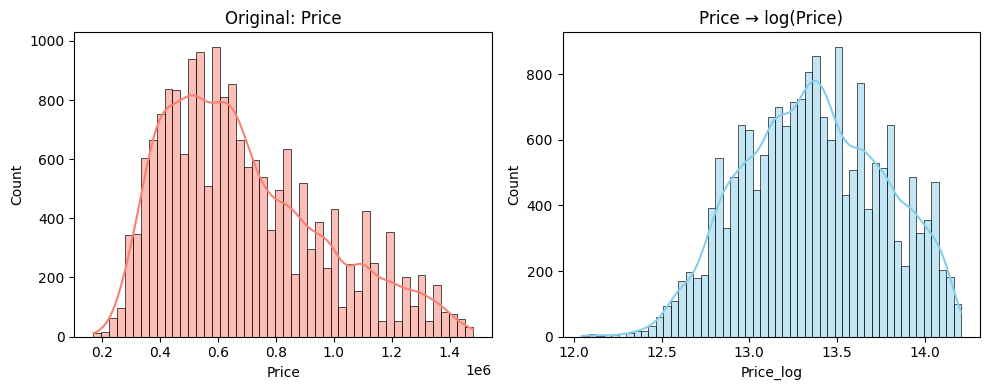

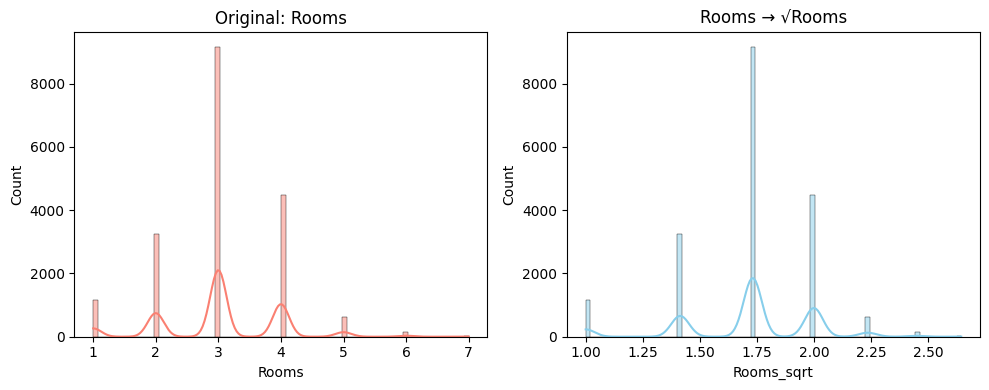

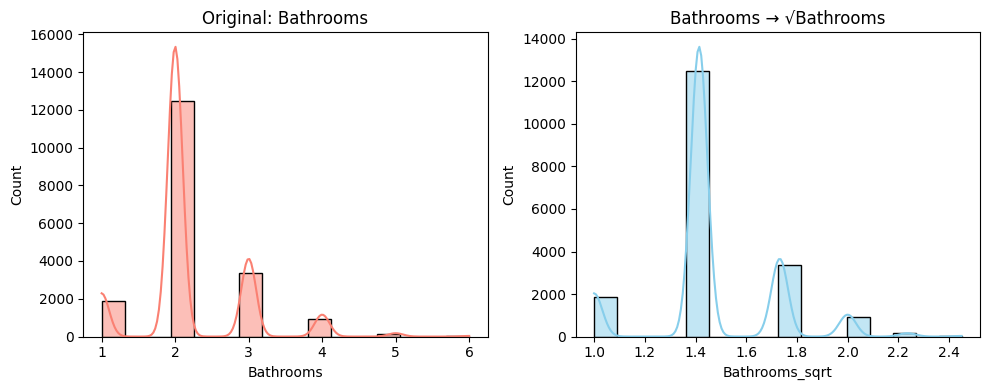

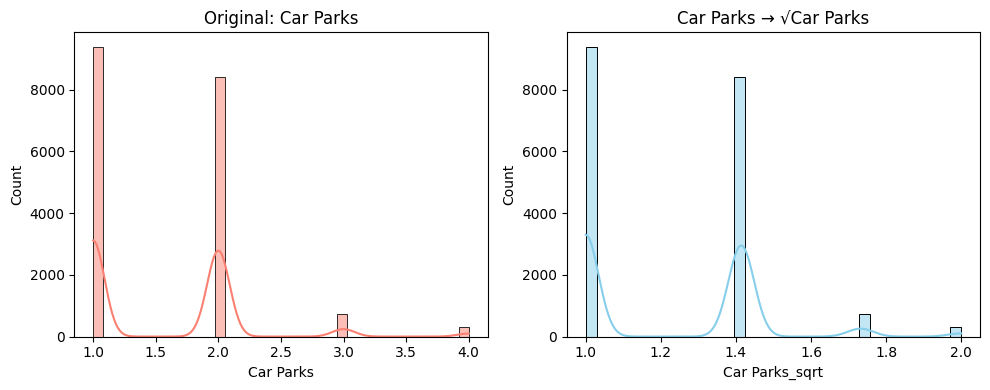

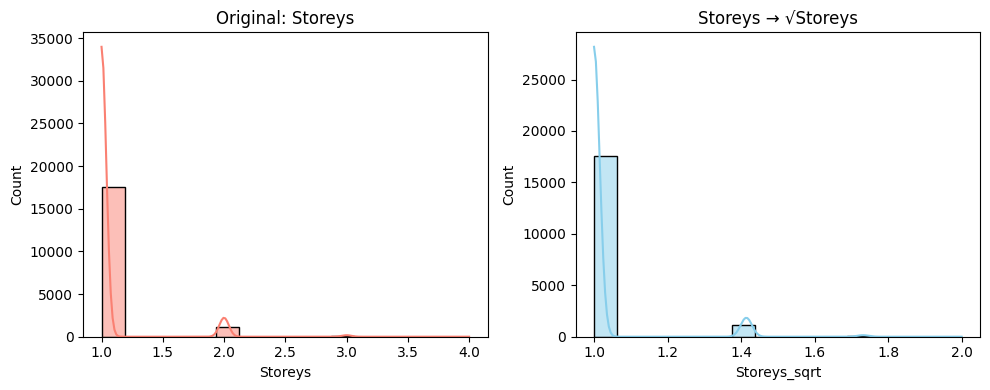

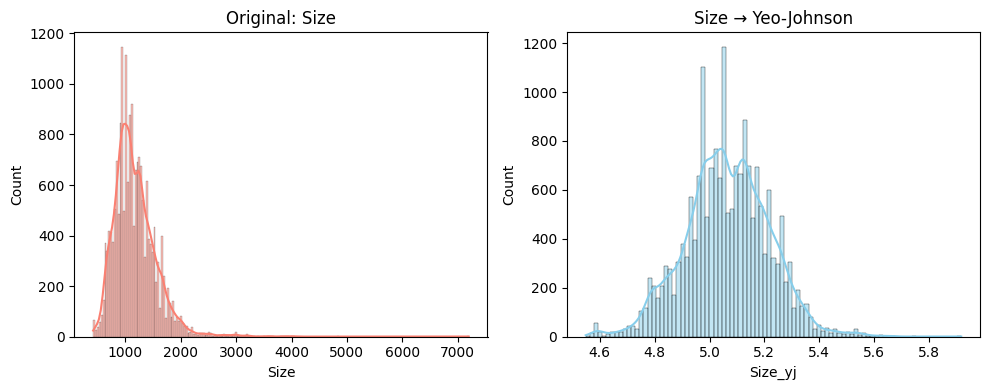

Transformed columns: ['Price_log', 'Rooms_sqrt', 'Bathrooms_sqrt', 'Car Parks_sqrt', 'Storeys_sqrt', 'Size_yj']
df_model shape: (18816, 6)


,Price_log,Rooms_sqrt,Bathrooms_sqrt,Car Parks_sqrt,Storeys_sqrt,Size_yj
0,13.038982,1.732051,1.414214,1.0,1.0,4.908851
1,12.971540,1.732051,1.414214,1.0,1.0,5.033795
2,13.081541,1.732051,1.414214,1.0,1.0,5.008121
3,13.028053,1.414214,1.414214,1.0,1.0,5.017669
4,13.028053,1.732051,1.414214,1.0,1.0,5.019159


In [14]:
# Numerical Data Transformation.

# 1. Features
num_cols = ['Price', 'Rooms', 'Bathrooms', 'Car Parks', 'Size', 'Storeys']
count_cols = ['Rooms', 'Bathrooms', 'Car Parks', 'Storeys']

# 2. Helper: before/after plot
def plot_before_after(df_source, col, transformed, title_after):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    sns.histplot(df_source[col].dropna(), kde=True, ax=axs[0], color='salmon')
    axs[0].set_title(f'Original: {col}')
    sns.histplot(transformed, kde=True, ax=axs[1], color='skyblue')
    axs[1].set_title(title_after)
    plt.tight_layout()
    plt.show()

# 3. Initialize transformed DataFrame + track new names
df_transformed = df_cleaned[num_cols].copy()
transformed_col_names = []

# 3.1 Price: log (add 1 if zeros)
if (df_cleaned['Price'] <= 0).any():
    df_transformed['Price_log'] = np.log1p(df_cleaned['Price'])
else:
    df_transformed['Price_log'] = np.log(df_cleaned['Price'])  # ← df_cleaned
transformed_col_names.append('Price_log')
plot_before_after(df_cleaned, 'Price', df_transformed['Price_log'], 'Price → log(Price)')

# 3.2 Count columns: log1p if zeros, else sqrt
for col in count_cols:
    if (df_cleaned[col] == 0).any():  # ← df_cleaned
        new_col = f'{col}_log1p'
        df_transformed[new_col] = np.log1p(df_cleaned[col])  # ← df_cleaned
        plot_before_after(df_cleaned, col, df_transformed[new_col], f'{col} → log1p({col})')
    else:
        new_col = f'{col}_sqrt'
        df_transformed[new_col] = np.sqrt(df_cleaned[col])  # ← df_cleaned
        plot_before_after(df_cleaned, col, df_transformed[new_col], f'{col} → √{col}')
    transformed_col_names.append(new_col)

# 3.3 Size: Yeo-Johnson (handles 0/neg)
pt = PowerTransformer(method='yeo-johnson', standardize=False)
df_transformed['Size_yj'] = pt.fit_transform(df_cleaned[['Size']]).flatten()  # ← df_cleaned
transformed_col_names.append('Size_yj')
plot_before_after(df_cleaned, 'Size', df_transformed['Size_yj'], 'Size → Yeo-Johnson')

# 4. Build final modeling dataframe
df_model = df_transformed[transformed_col_names].copy()
print("Transformed columns:", transformed_col_names)
print("df_model shape:", df_model.shape)  # ← Should be (18816, 7)
df_model.head()

In [15]:
# Categorical Data Transformation.

# 1. SimpleTargetEncoder (unchanged — good!)
class SimpleTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing=10):
        self.smoothing = smoothing

    def fit(self, X, y):
        X = pd.DataFrame(X)
        y = pd.Series(y, index=X.index)
        self.global_mean_ = y.mean()
        self.mappings_ = {}
        self.feature_names_in_ = list(X.columns)

        for i, col in enumerate(X.columns):
            df_temp = pd.DataFrame({'cat': X[col], 'target': y})
            stats = df_temp.groupby('cat')['target'].agg(['mean', 'count'])
            smooth = (stats['mean'] * stats['count'] + self.global_mean_ * self.smoothing) / (stats['count'] + self.smoothing)
            self.mappings_[i] = smooth.to_dict()
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        out = np.empty_like(X, dtype=float)
        for i, col in enumerate(X.columns):
            mapping = self.mappings_.get(i, {})
            default = self.global_mean_
            out[:, i] = X[col].map(mapping).fillna(default).values
        return out

    def get_feature_names_out(self, input_features=None):
        return self.feature_names_in_


# --------------------------------------------------------------
# 2. Use ONLY df_cleaned from now on
# --------------------------------------------------------------
cat_cols = df_cleaned.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Found {len(cat_cols)} categorical columns:", cat_cols)

# 3. Split by cardinality
low_card_cols  = [c for c in cat_cols if df_cleaned[c].nunique() <= 12]
high_card_cols = [c for c in cat_cols if df_cleaned[c].nunique() > 12]

print("\nLow-cardinality (One-Hot):", low_card_cols)
print("High-cardinality (Target):", high_card_cols)

# 4. Target column
target_col = 'Price_log'
y = df_model[target_col]  # ← df_model is already from df_cleaned → 18,816

# 5. Numeric columns excluding target
num_cols_to_keep = [c for c in df_model.columns if c != target_col]
print("Numeric features for modeling:", num_cols_to_keep)

# 6. Build ColumnTransformer
preprocess = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), low_card_cols),
        ('target', SimpleTargetEncoder(smoothing=10), high_card_cols),
        ('num', 'passthrough', num_cols_to_keep)
    ],
    remainder='drop'
)

# --------------------------------------------------------------
# 7. Combine data — BOTH from df_cleaned
# --------------------------------------------------------------
df_cats = df_cleaned[cat_cols]  # ← Explicit, safe
df_combined = pd.concat([df_cats, df_model], axis=1)

print(f"df_combined shape: {df_combined.shape}")  # ← Should be (18816, ...)

# --------------------------------------------------------------
# 8. Fit & transform
# --------------------------------------------------------------
X_encoded = preprocess.fit_transform(df_combined, y)

# --------------------------------------------------------------
# 9. Build correct column names
# --------------------------------------------------------------
ohe = preprocess.named_transformers_['ohe']
ohe_names = ohe.get_feature_names_out(low_card_cols).tolist()

target_names = high_card_cols
num_names = num_cols_to_keep

feature_names = ohe_names + target_names + num_names

print(f"Expected columns: {len(feature_names)}")
print(f"X_encoded shape: {X_encoded.shape}")  # ← (18816, 18)

# --------------------------------------------------------------
# 10. Final DataFrame — use df_combined.index (from df_cleaned)
# --------------------------------------------------------------
df_final = pd.DataFrame(X_encoded, columns=feature_names, index=df_combined.index)
X_final = df_final
y_final = y

print(f"\nSUCCESS! Final X: {X_final.shape}, y: {y_final.shape}")
X_final.head()

Found 4 categorical columns: ['Location', 'Type', 'Furnishing', 'Position']

Low-cardinality (One-Hot): ['Type', 'Furnishing', 'Position']
High-cardinality (Target): ['Location']
Numeric features for modeling: ['Rooms_sqrt', 'Bathrooms_sqrt', 'Car Parks_sqrt', 'Storeys_sqrt', 'Size_yj']
df_combined shape: (18816, 10)
Expected columns: 17
X_encoded shape: (18816, 17)

SUCCESS! Final X: (18816, 17), y: (18816,)


,Type_Condominium,Type_Flat,Type_Semi-detached House,Type_Serviced Residence,Type_Terrace/Link House,Type_Townhouse,Furnishing_Partly Furnished,Furnishing_Unfurnished,Position_EndLot,Position_Intermediate,Position_Unknown,Location,Rooms_sqrt,Bathrooms_sqrt,Car Parks_sqrt,Storeys_sqrt,Size_yj
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.408104,1.732051,1.414214,1.0,1.0,4.908851
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.413074,1.732051,1.414214,1.0,1.0,5.033795
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.413074,1.732051,1.414214,1.0,1.0,5.008121
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.413074,1.414214,1.414214,1.0,1.0,5.017669
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.413074,1.732051,1.414214,1.0,1.0,5.019159


## Step 5. Data Modelling (Model Comparison, Hyperparamter Tuning and Evaluation)

In [16]:
# Model Training and Evaluation.
# Assuming X_final and y_final are already prepared from the previous preprocessing steps.
# Also assuming necessary dataframes like df, df_model are in the environment if needed.

# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting Regressor': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'Support Vector Regressor': make_pipeline(StandardScaler(), SVR(kernel='rbf', C=1.0, epsilon=0.1))  # Added scaling for SVR
}

# Dictionary to store results
results = {
    'Model': [],
    'MSE': [],
    'RMSE': [],
    'MAE': [],
    'R²': []
}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Append to results
    results['Model'].append(name)
    results['MSE'].append(mse)
    results['RMSE'].append(rmse)
    results['MAE'].append(mae)
    results['R²'].append(r2)

# Create a DataFrame for comparison
comparison_df = pd.DataFrame(results)

# Print the comparison table
print("Model Comparison Table:")
print(comparison_df)

Model Comparison Table:
                         Model       MSE      RMSE       MAE        R²
0            Linear Regression  0.047623  0.218227  0.174583  0.698599
1      Random Forest Regressor  0.015807  0.125726  0.084173  0.899958
2  Gradient Boosting Regressor  0.023847  0.154426  0.116195  0.849073
3     Support Vector Regressor  0.036909  0.192116  0.148995  0.766409


In [17]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Focus on top 2: Random Forest and XGBoost
models_cv = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

cv_results = {}

print("5-Fold Cross-Validation (RMSE):")
for name, model in models_cv.items():
    cv_scores = cross_val_score(model, X_final, y_final, cv=5, scoring='neg_root_mean_squared_error')
    cv_rmse = -cv_scores  # Convert back to positive
    cv_results[name] = cv_rmse
    print(f"{name}: Mean RMSE = {cv_rmse.mean():.4f} ± {cv_rmse.std():.4f}")

5-Fold Cross-Validation (RMSE):
Random Forest: Mean RMSE = 0.1441 ± 0.0035
XGBoost: Mean RMSE = 0.1643 ± 0.0029


In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Define parameter grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 4),
    'max_features': ['auto', 'sqrt', 0.5, 0.7]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=50,
    cv=5, scoring='neg_root_mean_squared_error',
    random_state=42, n_jobs=-1
)

random_search.fit(X_final, y_final)

print("Best Parameters:", random_search.best_params_)
print("Best CV RMSE:", -random_search.best_score_)

Best Parameters: {'max_depth': 30, 'max_features': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 413}
Best CV RMSE: 0.14275793992509558


In [19]:
# Final model (example: tuned RF)
best_rf = random_search.best_estimator_

# Split: 80% train, 20% test (fresh split!)
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=99)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

print("FINAL TEST PERFORMANCE")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE:  {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R²:   {r2_score(y_test, y_pred):.4f}")

FINAL TEST PERFORMANCE
RMSE: 0.1262
MAE:  0.0854
R²:   0.9005


In [20]:
# Feature importance
importances = best_rf.feature_importances_
feat_imp = pd.Series(importances, index=X_final.columns).sort_values(ascending=False)
print(feat_imp.head(10))

Location                       0.425947
Size_yj                        0.339286
Bathrooms_sqrt                 0.051881
Car Parks_sqrt                 0.050912
Type_Serviced Residence        0.034183
Rooms_sqrt                     0.032459
Type_Condominium               0.016334
Furnishing_Partly Furnished    0.009124
Position_Intermediate          0.009061
Furnishing_Unfurnished         0.008347
dtype: float64


In [21]:
y_pred_price = np.exp(y_pred)
y_test_price = np.exp(y_test)

# Mean Absolute Error in dollars
mae_dollars = mean_absolute_error(y_test_price, y_pred_price)
print(f"MAE in original price: ${mae_dollars:,.2f}")

MAE in original price: $57,581.08


In [22]:
# Additional imports (if not already present)
from sklearn.preprocessing import FunctionTransformer, PowerTransformer
from sklearn.pipeline import Pipeline
import joblib

# Define X and y from original cleaned data (before manual transforms)
X = df_cleaned.drop('Price', axis=1)  # Original features only
y = np.log(df_cleaned['Price'])  # Assuming Price > 0; use np.log1p if <=0 possible

# Extract unique values for app dropdowns (sort for better UX)
options = {
    'locations': sorted(df_cleaned['Location'].unique().tolist()),
    'types': sorted(df_cleaned['Type'].unique().tolist()),
    'furnishings': sorted(df_cleaned['Furnishing'].unique().tolist()),
    'positions': sorted(df_cleaned['Position'].unique().tolist())
}

# Define custom transformers for numerical features
log1p_trans = FunctionTransformer(np.log1p)
sqrt_trans = FunctionTransformer(np.sqrt)
yeo_trans = PowerTransformer(method='yeo-johnson', standardize=False)

# Full preprocessing ColumnTransformer (applies to original features)
preprocess = ColumnTransformer(
    transformers=[
        ('rooms_sqrt', sqrt_trans, ['Rooms']),  # Adjust to log1p_trans if your code used log1p
        ('bathrooms_sqrt', sqrt_trans, ['Bathrooms']),  # Adjust if needed
        ('car_parks_log1p', log1p_trans, ['Car Parks']),  # Assuming has zeros
        ('storeys_sqrt', sqrt_trans, ['Storeys']),  # Adjust if needed
        ('size_yeo', yeo_trans, ['Size']),
        ('ohe', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), low_card_cols),  # low_card_cols = ['Type', 'Furnishing', 'Position']
        ('target', SimpleTargetEncoder(smoothing=10), high_card_cols)  # high_card_cols = ['Location']
    ],
    remainder='drop'
)

# Full pipeline: Preprocessing + your tuned model
best_params = random_search.best_params_  # From your hyperparameter tuning
pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', RandomForestRegressor(**best_params, random_state=42))
])

# Fit the pipeline
pipeline.fit(X, y)

# Save pipeline and options to PKL
joblib.dump({'pipeline': pipeline, 'options': options}, 'house_price_model.pkl')
print("PKL file saved successfully!")

PKL file saved successfully!
